# GBNRTC Example Model

In [1]:
import emat
emat.require_version('0.5.0b1')

emat 0.5.0b1, workbench 2.1.509, plotly 4.12.0


In [2]:
import pandas, numpy, os

In [3]:
scope = emat.Scope('gbnrtc_scope.yaml')

In [4]:
db = emat.SQLiteDB()

In [5]:
scope.store_scope(db)

The basic operation of the GBNRTC model can be controlled by EMAT through a custom developed 
class, which defines the input and output "hooks" that are consistent with the defined 
scope file.  The `GBNRTCModel` class is able to call to TransCAD, setup the input parameters
(exogenous uncertainties, policy levers, and constants defined in the scope), exceute the 
model, and retrieve the performance measure results.  

In [6]:
from emat.model import GBNRTCModel

In [7]:
g = GBNRTCModel(
    configuration='gbnrtc_model_config.yaml',
    scope=scope,
    db=db,
)
g

The GBNRTC model takes a couple of hours for each run, and runs in TransCAD, which 
is a proprietary software package that is not included with the EMAT distribution.
However, for demonstration purposes, the definition and results of a particular set 
of experiments is included in the file `buffalo.csv`.  We can use 
the `write_experiment_all` method to pre-load these results into the database.

In [8]:
lhs = pandas.read_csv('buffalo.csv')

In [9]:
lhs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 92 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   expmntID                                                          60 non-null     int64  
 1   Land Use - CBD Focus                                              60 non-null     float64
 2   Freeway Capacity                                                  60 non-null     float64
 3   Auto IVTT Sensitivity                                             60 non-null     float64
 4   Shared Mobility                                                   60 non-null     float64
 5   Kensington Decommissioning                                        60 non-null     float64
 6   LRT Extension                                                     60 non-null     float64
 7   Region-wide VMT                      

In [10]:
db.write_experiment_all(
    'GBNRTC', 
    'lhs', 
    emat.SOURCE_IS_CORE_MODEL, 
    lhs,
)

In [11]:
len(g.read_experiments('lhs'))

60

In [12]:
len(g.read_experiments('lhs', only_pending=True))

0

The example data contains a large variety of output performance measures, as 
TransCAD models can potentially output a lot of data.

In [13]:
g.scope.get_measure_names()

['Region-wide VMT',
 'Interstate + Expressway + Ramp/Connector VMT',
 'Major and Minor Arterials VMT',
 'Total Auto VMT',
 'Total Truck VMT',
 'AM Trip Time (minutes)',
 'AM Trip Length (miles)',
 'PM Trip Time (minutes)',
 'PM Trip Length (miles)',
 'Total Transit Boardings',
 'Total LRT Boardings',
 'Downtown to Airport Travel Time',
 'Households within 30 min of CBD',
 'Number of Home-based work tours taking <= 45 minutes via transit',
 'Kensington Daily VMT',
 'Kensington Daily VHT',
 'Kensington_OB PM VMT',
 'Kensington_OB PM VHT',
 'Kensington_IB AM VMT',
 'Kensington_IB AM VHT',
 'Corridor 190 Daily VMT',
 'Corridor 190 Daily VHT',
 'Corridor 190_OB Daily VMT',
 'Corridor 190_OB Daily VHT',
 'Corridor 190_IB Daily VMT',
 'Corridor 190_IB Daily VHT',
 'Corridor 33_west Daily VMT',
 'Corridor 33_west Daily VHT',
 'Corridor I90_south Daily VMT',
 'Corridor I90_south Daily VHT',
 'OD Volume District 1 to 1',
 'OD Volume District 1 to 2',
 'OD Volume District 1 to 3',
 'OD Volume Dis

The high level scope
definition is designed to capture all of this data for later analysis, but
in this demonstration we will only evaluate a few of these performance measures.
In part, this is because creating meta-models for each performance measure is 
relatively inexpensive (computationally speaking) but not free -- it can take 
a few seconds to create the meta-model and it is not needed here if we are not 
interested in all these results for this analysis.

Creating a meta-model for analysis of an existing model with a completed 
design of experiments can be done using the `create_metamodel_from_design` 
method. To create a meta-model on a more limited scope, we can use the 
`include_measures` argument to list out a subset of measures that will be
included in this metamodel.

In [14]:
mm = g.create_metamodel_from_design(
    'lhs',
    include_measures=[
        'Region-wide VMT', 
        'AM Trip Time (minutes)',
        'Downtown to Airport Travel Time',
        'Total Transit Boardings',
        'Peak Transit Share', 
        'Peak NonMotorized Share',
        'Corridor Kensington Daily VMT',
        'Corridor 190 Daily VMT',
        'Corridor 33_west Daily VMT',
        'Corridor I90_south Daily VMT',
    ]
)
mm

<emat.PythonCoreModel "MetaModel1", metamodel_id=1 with 4 uncertainties, 2 levers, 9 measures>

You might notice that the class of the meta-model is no longer a `GBNRTCModel`
but instead now it is a `PythonCoreModel`.  This is because at its heart, the
meta-model is a Python function that wraps the gaussian process regression that
has been fit to the available experimental data.  Also, although the scope still
has 46 measures, only 10 are active in the actual meta-model:

In [15]:
mm.function

<emat.MetaModel 6 inputs -> 9 active and 46 total outputs>

In [16]:
callable(mm.function)

True

In [17]:
mm.function.regression

BoostedRegressor(estimators=[('lr', LinearRegression()),
                             ('gpr',
                              MultiOutputRegressor(estimator=AnisotropicGaussianProcessRegressor()))])

In [18]:
mm.function.regression.lr.r2

Region-wide VMT                    0.996544
AM Trip Time (minutes)             0.975504
Total Transit Boardings            0.979225
Downtown to Airport Travel Time    0.958725
Corridor 190 Daily VMT             0.987302
Corridor 33_west Daily VMT         0.985156
Corridor I90_south Daily VMT       0.990920
Peak Transit Share                 0.968484
Peak NonMotorized Share            0.972930
dtype: float64

In [19]:
mm.function.regression.lr.coefficients_summary()

Coefficient  StdError  \
Region-wide VMT         Land Use - CBD Focus           0.716566  0.005804   
                        Freeway Capacity               0.016095  0.002926   
                        Auto IVTT Sensitivity         -0.087768  0.011870   
                        Shared Mobility                0.056346  0.003111   
                        Kensington Decommissioning    -0.002179  0.001219   
...                                                         ...       ...   
Peak NonMotorized Share Auto IVTT Sensitivity          0.004077  0.002633   
                        Shared Mobility               -0.022950  0.000690   
                        Kensington Decommissioning    -0.000207  0.000270   
                        LRT Extension                  0.000080  0.000267   
                        _Intercept_                    0.038900  0.002846   

                                                    t-Statistic             p  
Region-wide VMT         Land Use - CBD Focus         123.451376  0.000000e+00  
                        Freeway Capacity               5.500103  1.064930e-06  
                        Auto IVTT Sensitivity         -7.394311  9.431564e-10  
                        Shared Mobility               18.112700  0.000000e+00  
                        Kensington Decommissioning    -1.786796  7.958416e-02  
...                                                         ...           ...  
Peak NonMotorized Share Auto IVTT Sensitivity          1.548439  1.273580e-01  
                        Shared Mobility              -33.259215  0.000000e+00  
                        Kensington Decommissioning    -0.764370  4.479741e-01  
                        LRT Extension                  0.298330  7.665962e-01  
                        _Intercept_                   13.666207  0.000000e+00  

[63 rows x 4 columns]

In [20]:
mm.function.cross_val_scores()

,Cross Validation Score
Region-wide VMT,0.9964
AM Trip Time (minutes),0.9819
Total Transit Boardings,0.9963
Downtown to Airport Travel Time,0.9683
Corridor 190 Daily VMT,0.9854
Corridor 33_west Daily VMT,0.9848
Corridor I90_south Daily VMT,0.9900
Peak Transit Share,0.9904
Peak NonMotorized Share,0.9924


To use the metamodel for exploratory analysis, we can design and run a large
number of experiments.

In [21]:
design = mm.design_experiments(n_samples=10000, sampler='lhs')

The meta-model evaluates pretty quickly, but not instantaneously.  To speed up the 
evaluation for this large number of experiments, we can parallelize the execution
by using `async_experiments`.

In [22]:
result = await mm.async_experiments(design, max_n_workers=8).final_results()

IntProgress(value=0, max=10000)

If we inspect the results, we see that among the performance measures, only the 
active measures have non-null computed values:

In [23]:
result.info()

<class 'emat.experiment.experimental_design.ExperimentalDesign'>
Int64Index: 10000 entries, 61 to 10060
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Land Use - CBD Focus             10000 non-null  float64
 1   Freeway Capacity                 10000 non-null  float64
 2   Auto IVTT Sensitivity            10000 non-null  float64
 3   Shared Mobility                  10000 non-null  float64
 4   Kensington Decommissioning       10000 non-null  bool   
 5   LRT Extension                    10000 non-null  bool   
 6   Region-wide VMT                  10000 non-null  float64
 7   AM Trip Time (minutes)           10000 non-null  float64
 8   Total Transit Boardings          10000 non-null  float64
 9   Downtown to Airport Travel Time  10000 non-null  float64
 10  Corridor 190 Daily VMT           10000 non-null  float64
 11  Corridor 33_west Daily VMT       10000 non-null  flo

The results of these meta-model experiments can be used for visualization and
other exploratory modeling applications.

<xmle.Elem 'img' with 0 children>
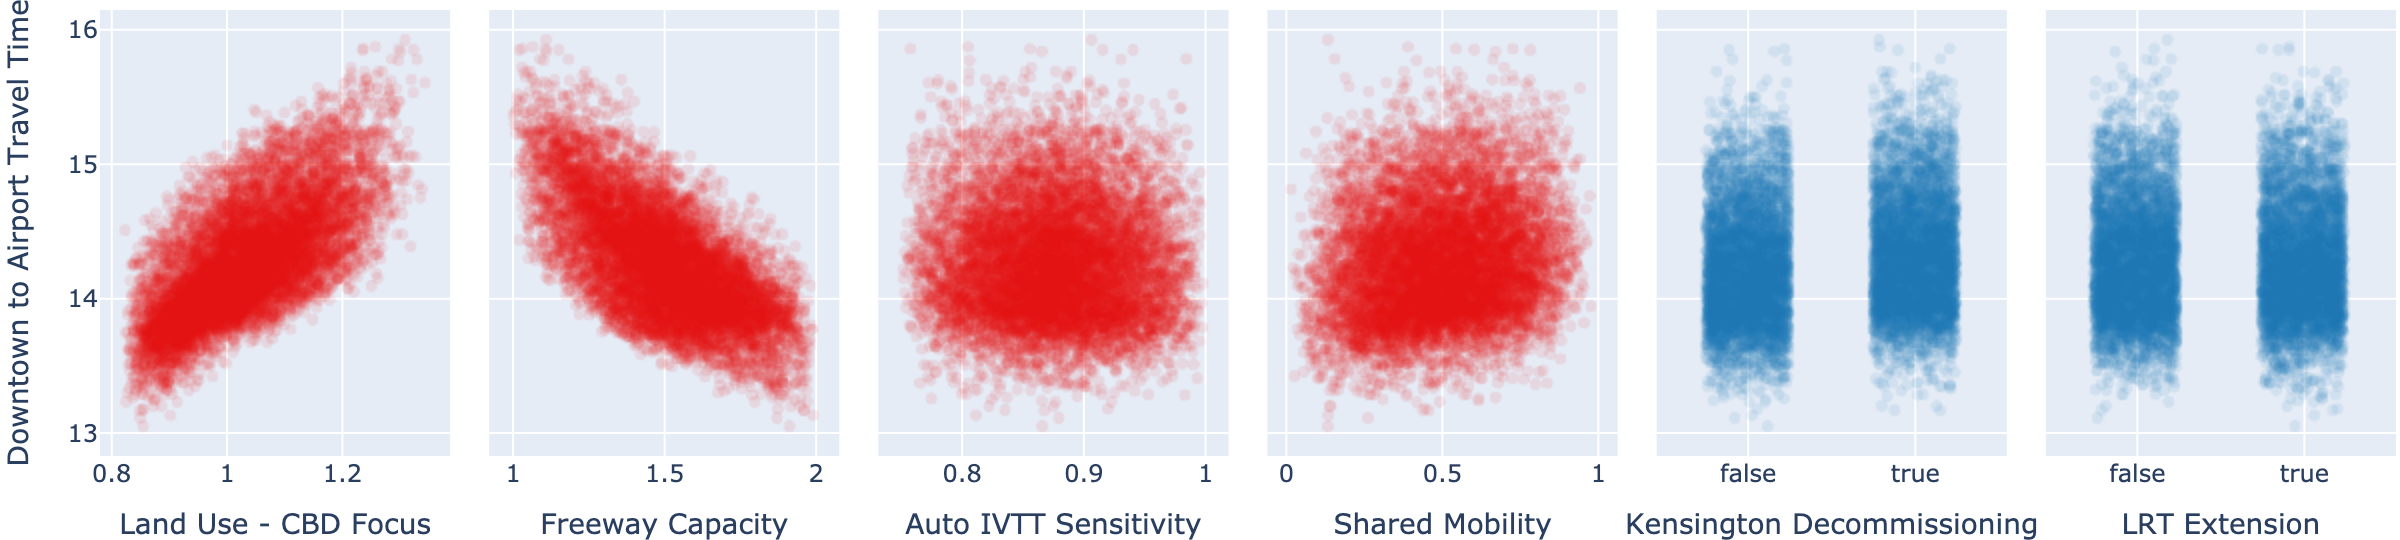

In [24]:
from emat.viz import scatter_graphs
scatter_graphs('Downtown to Airport Travel Time', result, scope=mm.scope, render='png')